# Compare results from two git branches
With this notebook, you can quickly compare the model results of two different git branches of STEMMUS_SCOPE.

In the following cell, you configure the local setup. The config template (pointing to the right data directories) needs to be set up correctly.
Additionally, you need to have a local clone of the `EcoExtreML/STEMMUS_SCOPE` github repository.

You also need to specify what you use to run the model (Octave or Matlab), and which branches you would like to compare.

Lastly, you configure for which site you want to run the model, and for what start and end times:

In [1]:
# user must provide the correct path
path_to_config_template = "/media/bart/OS/STEMMUS_SCOPE_data/config_template.txt"
path_to_repository = "/home/bart/git/STEMMUS_SCOPE"
required_netcdf_variables = path_to_repository + "/utils/csv_to_nc/required_netcdf_variables.csv"

# Setup the runner: Octave/Matlab, and the git branches here:
runner = "Octave"  # alternatively "Matlab", or "executable"
test_branch = "efecapcond-168"
main_branch = "main"

# Configure your desired site here:
model_location = "ZA-Kru"
model_start = "2001-01-01T00:00"
model_end = "2001-01-08T00:00"

Before continuing, run the following command to ensure that you can change between the two branches without any errors:

In [ ]:
!cd $path_to_repository; git checkout $main_branch; git pull
!cd $path_to_repository; git checkout $test_branch; git pull

### The rest of the notebook should not need any changes. Just do Run All 😃🚀
Once the models have been run, the bottom of this notebook will contain the output analysis.

In [2]:
from PyStemmusScope import StemmusScope
from PyStemmusScope import save
from pathlib import Path

if runner in ("Octave", "Matlab"):
    model_source = path_to_repository + "/src"
    model = StemmusScope(
        config_file=path_to_config_template, 
        model_src_path=model_source,
        interpreter=runner,
    )
elif runner == "executable":
    model_source = path_to_repository + "/exe/STEMMUS_SCOPE"
    model = StemmusScope(
        config_file=path_to_config_template,
        model_src_path=model_source,
    )
else:
    raise ValueError("Unknown runner")

config_path = model.setup(
    Location=model_location,
    StartTime=model_start,
    EndTime=model_end,
)

In [3]:
!cd $path_to_repository; git checkout $main_branch; git pull

M	PyStemmusScope/stemmus_scope.py
M	docs/notebooks/run_model_in_notebook.ipynb
M	docs/notebooks/verify_model_modifications.ipynb
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [ ]:
result = model.run()
print(result)
nc_file_main = save.to_netcdf(config_path, required_netcdf_variables)
nc_file_main = Path(nc_file_main).rename(
    str(nc_file_main).replace(".nc", "__main_run.nc")
)

In [13]:
!cd $path_to_repository; git checkout $test_branch; git pull

Switched to branch 'efecapcond-168'
Your branch is up to date with 'origin/efecapcond-168'.
Already up to date.


In [ ]:
result = model.run()
nc_file_test = save.to_netcdf(config_path, required_netcdf_variables)
nc_file_test = Path(nc_file_test).rename(
    str(nc_file_test).replace(".nc", "__test_run.nc")
)

In [16]:
import xarray as xr
ds_main = xr.open_dataset(nc_file_main)
ds_test = xr.open_dataset(nc_file_test)

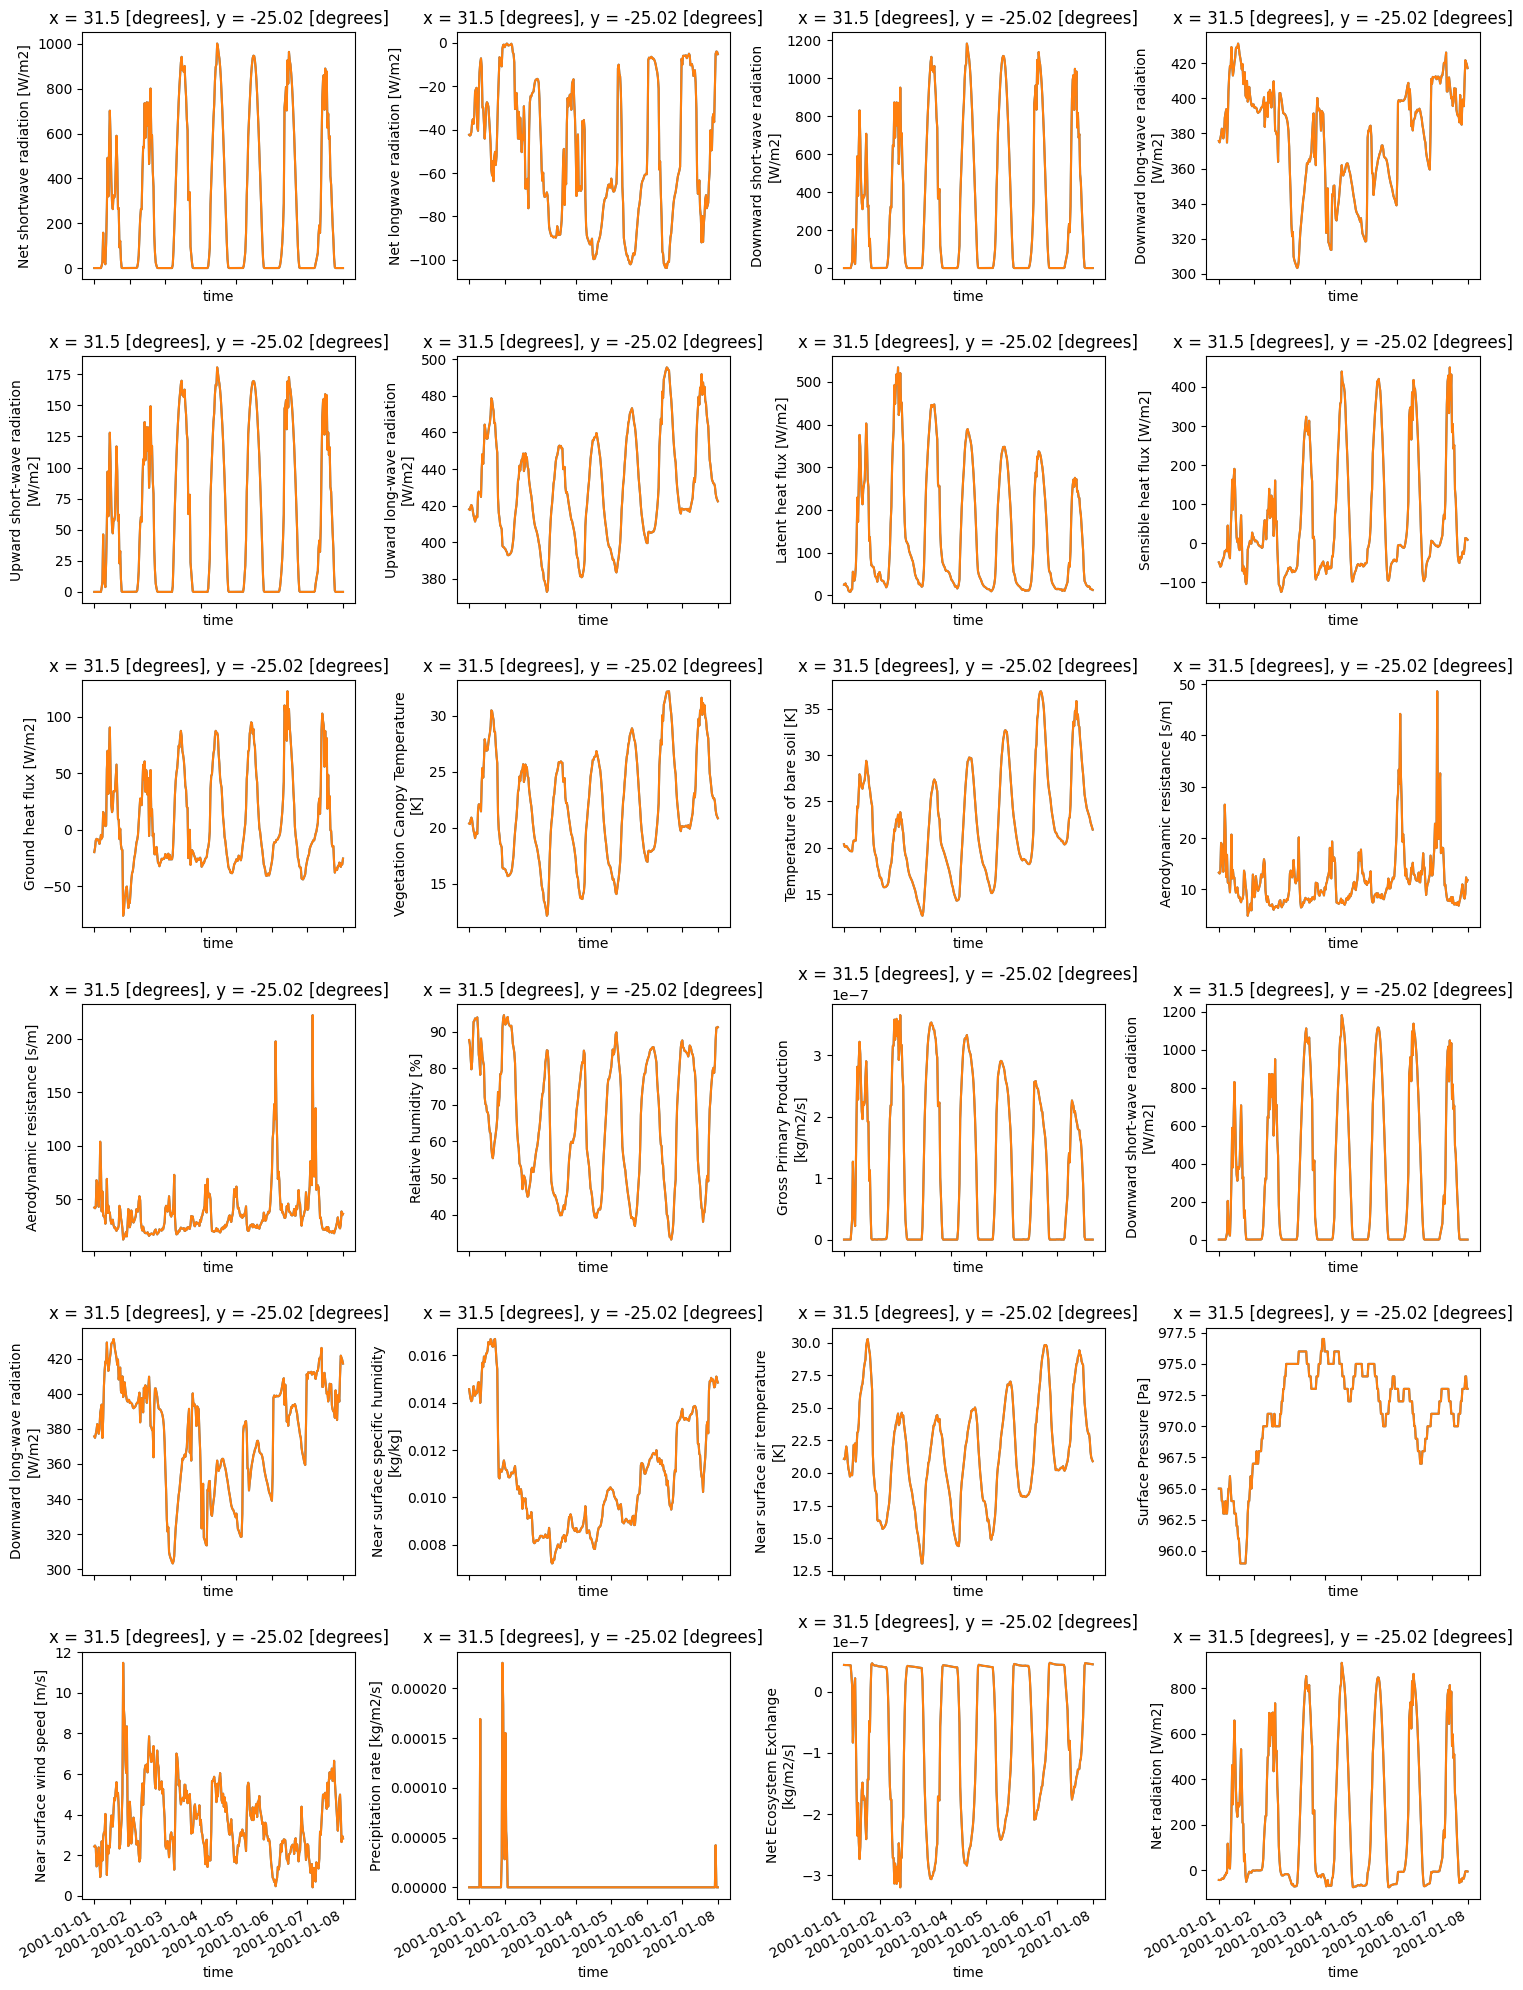

In [34]:
import numpy as np
import matplotlib.pyplot as plt

all_keys = list(ds_main.keys())
keys_3dvars = ("SoilTemp", "SoilMoist")
keys_2dvars = [key for key in all_keys if key not in keys_3dvars]

nplots = len(keys_2dvars)
ncols = 4 
nrows = np.ceil(nplots/ncols).astype(int)

fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(15,20))
axes = axes.flatten()

for i, key in enumerate(keys_2dvars):
    ds_main[key].plot(ax=axes[i])
    ds_test[key].plot(ax=axes[i])

plt.tight_layout()

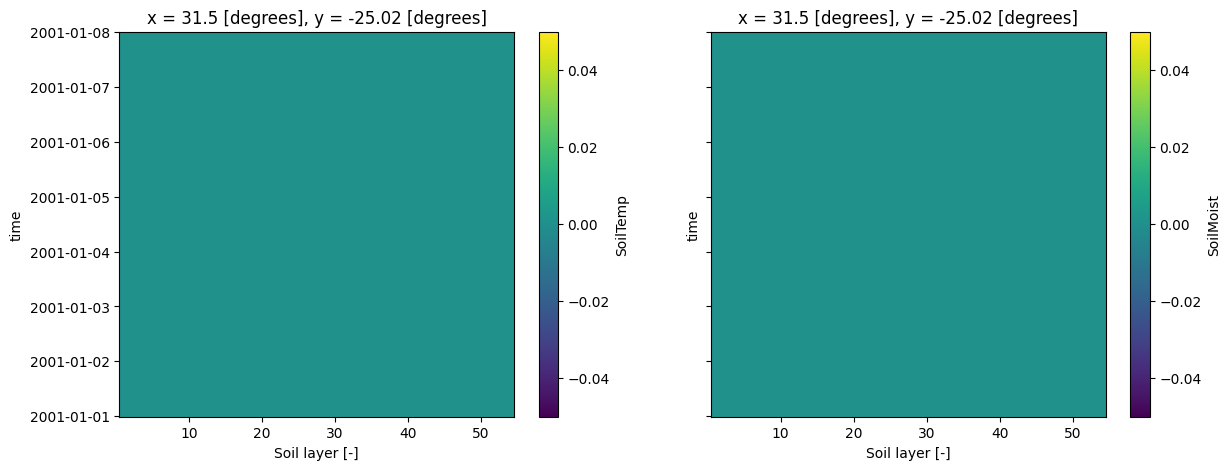

In [39]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
for i, key in enumerate(keys_3dvars):
    (ds_test[key] - ds_main[key]).plot(ax=axes[i])

In [40]:
for key in ds_main.keys():
    np.testing.assert_allclose(
        ds_main[key],
        ds_test[key],
        rtol=1e-4,
        atol=np.abs(ds_main[key]).mean().values / 1000  # to allow for a small difference when the variable's value crosses 0.
    )